Running a tobit style regression in Stan.

In [1]:
# set up Python
from typing import Iterable
import logging
import numpy as np
import pandas as pd
from plotnine import *
from cmdstanpy import CmdStanModel
from sklearn.linear_model import LinearRegression

# quiet down Stan
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())

In [2]:
rng = np.random.default_rng(2024)

In [3]:
# from 
# https://win-vector.com/2024/08/16/post-hoc-adjustment-for-zero-thresholded-linear-models/
def true_process(mu: float = 0.0, N: int = 500):
  x = 3 * rng.normal(size=N, loc=mu)
  f_x = x / np.e - 1
  y = np.maximum(0.0, f_x + 0.5 * rng.normal(size=N))
  y_ideal = np.maximum(0.0, f_x)
  df = pd.DataFrame({
    'x': x, 
    'y': y, 
    'y_ideal': y_ideal,
    })
  return df

d_train = true_process()
d_test = true_process()


d_train

,x,y,y_ideal
0,3.086571,0.000000,0.135486
1,4.925760,0.901341,0.812086
2,3.440159,0.507536,0.265564
3,-2.919539,0.000000,0.000000
4,-4.178400,0.000000,0.000000
...,...,...,...
495,-0.125290,0.000000,0.000000
496,3.975848,0.208396,0.462633
497,-3.384108,0.000000,0.000000
498,2.888455,0.000000,0.062603


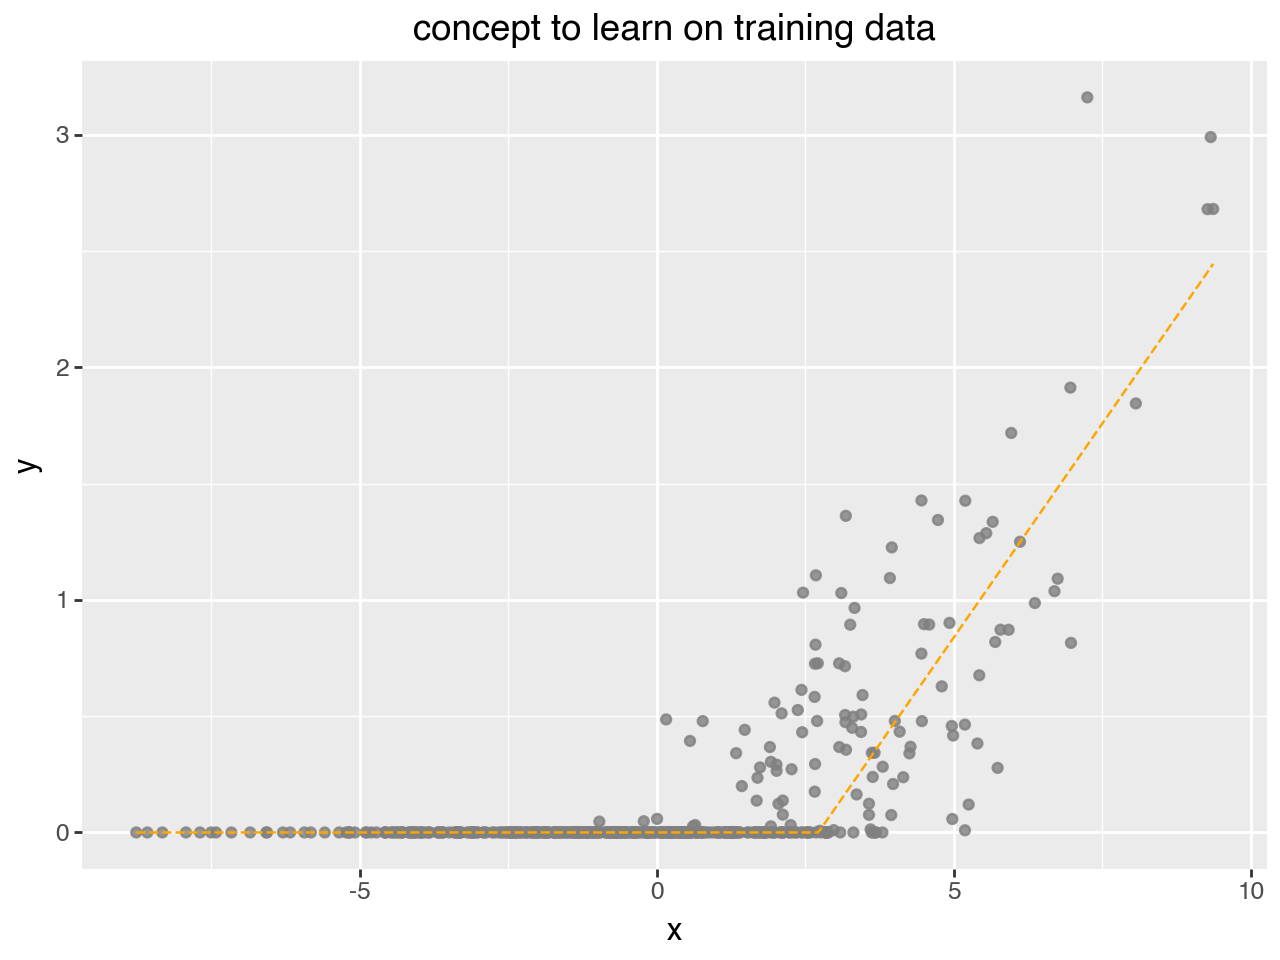

In [4]:
(
    ggplot(
        data=d_train, 
        mapping=aes(x='x')) + 
    geom_point(
        mapping=aes(y='y'),
        color="gray", alpha=0.8) + 
    geom_line(
        mapping=aes(y='y_ideal'),
        color="orange", linetype='--') + 
    ggtitle("concept to learn on training data")
)

In [5]:

lm0 = LinearRegression()
lm0.fit(
    d_train.loc[:, ['x']],
    d_train.loc[:, 'y'],
)

d_test['ypred0'] = np.maximum(
    0, 
    lm0.predict(d_test.loc[:, ['x']]))

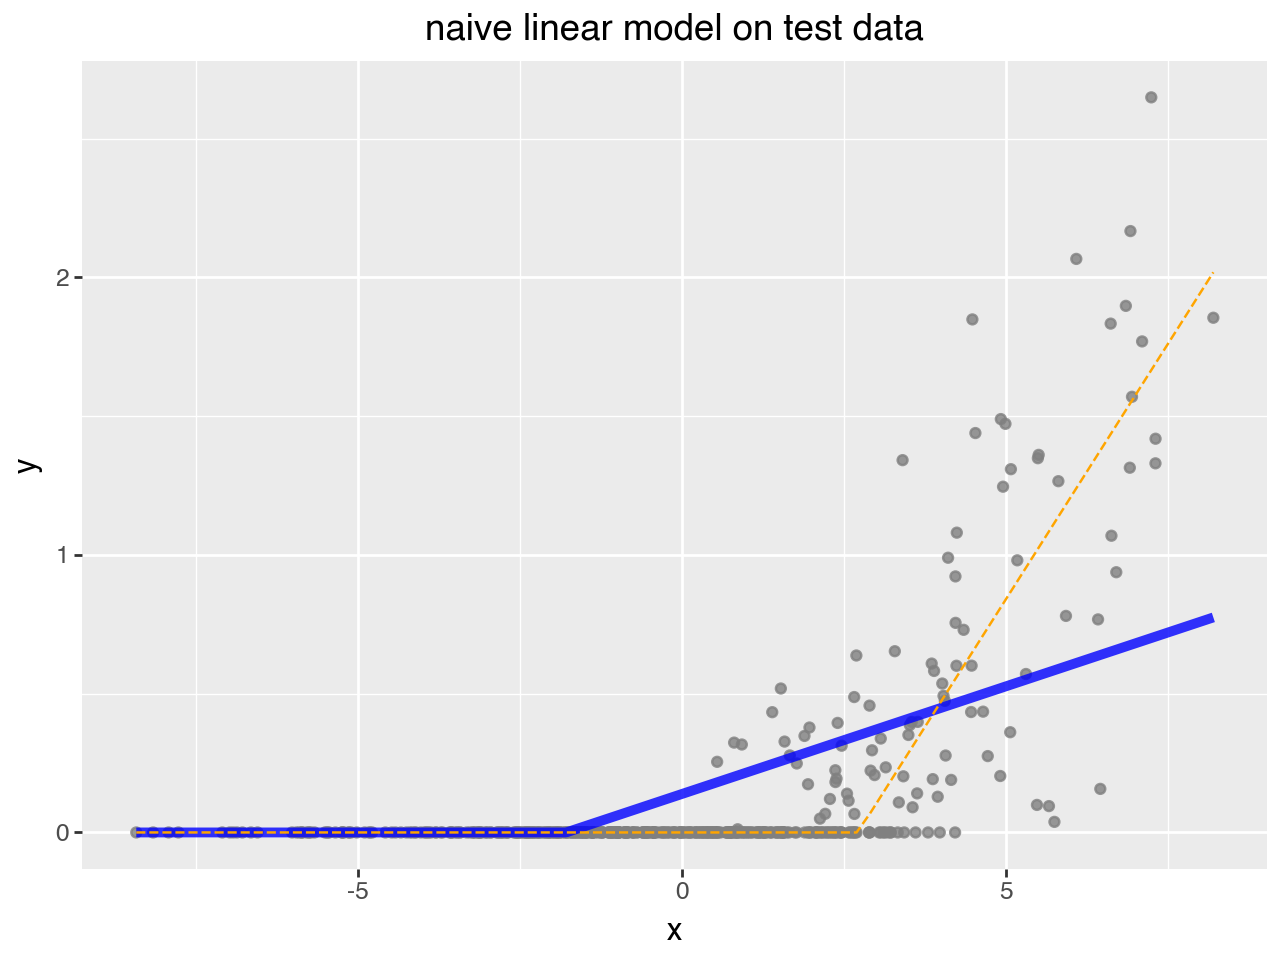

In [6]:
(
    ggplot(
        data=d_test, 
        mapping=aes(x='x')) + 
    geom_point(
        mapping=aes(y='y'),
        color="gray", alpha=0.8) + 
    geom_line(
        mapping=aes(y='ypred0'),
        color="blue",
        alpha=0.8,
        size=2) + 
    geom_line(
        mapping=aes(y='y_ideal'),
        color="orange", linetype='--') + 
    ggtitle("naive linear model on test data")
)

In [7]:
stan_model_src = """
data {
  int<lower=0> N_positive;   // number of positive observations
  int<lower=0> N_zero;       // number of zero observations
  vector[N_positive] x_pos;  // explanatory variable for positive outcomes
  vector[N_positive] y_pos;  // observed positive outcomes
  vector[N_zero] x_zero;     // explanatory variable for non-positive outcomes
}
parameters {
  real a;                    // regression slope
  real b;                    // regression intercept
  real<lower=0> sigma;       // variance
}
model {
      // basic priors
  a ~ normal(0, 10);
  b ~ normal(0, 10);
  sigma ~ chi_square(1);
      // tobit style model structure
  target += normal_lpdf(y_pos | a * x_pos + b, sigma);
  target += normal_lcdf( 0 | a * x_zero + b, sigma);
}
"""

# target += adds to log probability, and stan maximizes
# see https://mc-stan.org/docs/2_18/reference-manual/increment-log-prob-section.html

In [8]:
pos_positions = d_train['y'] > 0
x_pos = list(d_train['x'][pos_positions])
y_pos = list(d_train['y'][pos_positions])
x_zero = list(d_train['x'][pos_positions == False])

In [9]:
# build model
stan_file = 'tobit_tmp.stan'
with open(stan_file, 'w', encoding='utf8') as file:
    file.write(stan_model_src)
# instantiate the model object
model = CmdStanModel(stan_file=stan_file)


In [10]:
data_str = f"""
{{
    "N_positive" : {len(x_pos)},
    "N_zero" : {len(x_zero)},
    "x_pos" : {x_pos},
    "y_pos" : {y_pos},
    "x_zero" : {x_zero}
}}
"""

print(data_str)


{
    "N_positive" : 109,
    "N_zero" : 391,
    "x_pos" : [4.92576012201345, 3.440158588789841, 5.430856722885849, 2.252530419461755, 1.9192786617943873, 4.453216757051106, 2.4345603509446727, 2.709189233230887, 4.973052165593791, 3.597561496848706, 3.6335834081054097, 1.9029028243320547, 5.5445018859632, 4.005812186246286, 3.4370317016746985, 2.660706213350811, 5.920666020987925, 3.166924631431211, 2.372030148446804, 2.6553923886981328, 6.746424225317705, 6.961060142298645, 0.5578287926290123, 1.2152051516700768, 3.104850451055723, 5.652779100275561, 4.583876345220418, 3.1688990281091662, 1.6939591301816832, 5.965120191296535, 2.670589396708531, 7.245402443506883, 4.251428394394446, 0.6456580862219304, 2.6570134604429745, 5.186585696874835, 5.7842603865958635, 3.570509750396085, 2.676754181552428, 3.3276281449657654, 6.692642203185458, 3.6189871920428356, 3.5707636410773644, 4.087003682378647, 1.4302077427965552, 3.0675686049433395, 3.9228039002163, 4.795170048928563, 4.73198929054

In [11]:
data_file = "tobit_tmp.json"
with open(data_file, 'w', encoding='utf8') as file:
    file.write(data_str)

In [12]:
fit = model.sample(
    data=data_file,
    show_progress=False,
    show_console=False,
    )

In [13]:
res = fit.draws_pd()

In [14]:
res

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,a,b,sigma
0,-142.472,0.937533,0.304347,3.0,9.0,0.0,142.981,0.366051,-0.975112,0.570991
1,-141.741,0.933855,0.304347,3.0,15.0,0.0,144.435,0.355511,-0.984521,0.550613
2,-141.403,0.999116,0.304347,3.0,15.0,0.0,141.896,0.352065,-0.937340,0.491806
3,-141.947,0.897991,0.304347,2.0,3.0,0.0,142.651,0.364830,-0.924860,0.494647
4,-142.688,0.893235,0.304347,3.0,7.0,0.0,143.624,0.344572,-0.836164,0.516140
...,...,...,...,...,...,...,...,...,...,...
3995,-143.295,0.922740,0.335124,2.0,7.0,0.0,143.564,0.360355,-1.041390,0.524884
3996,-142.978,1.000000,0.335124,2.0,3.0,0.0,143.671,0.358598,-1.028050,0.521009
3997,-142.581,0.964141,0.335124,2.0,5.0,0.0,145.841,0.350171,-1.003430,0.546640
3998,-142.130,0.988814,0.335124,3.0,7.0,0.0,143.509,0.374963,-0.965537,0.526218


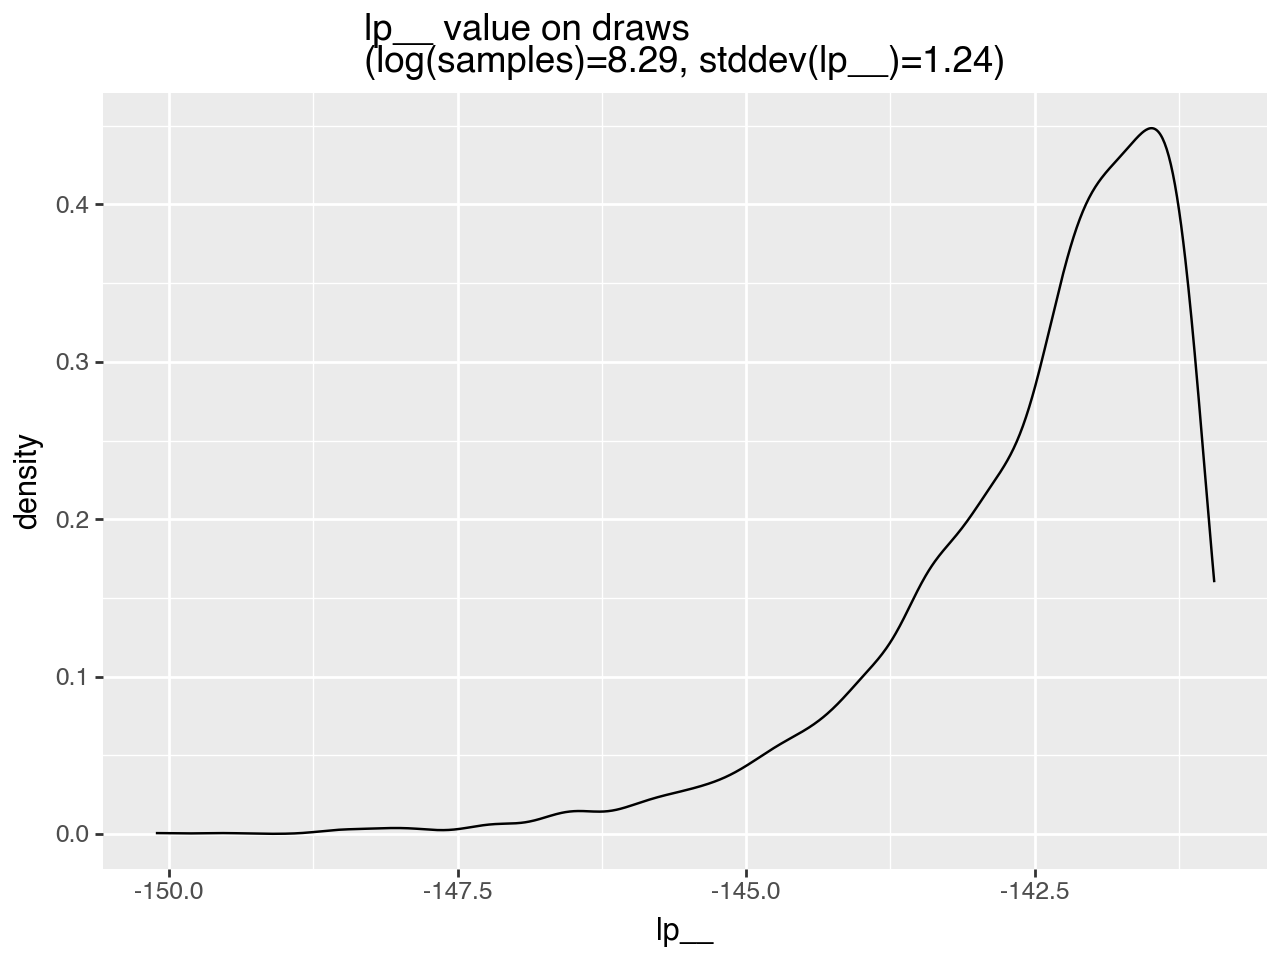

In [15]:
log_n_res = np.log(res.shape[0])
std_lp = np.std(res['lp__'])
(
    ggplot(
        data=res,
        mapping=aes(x='lp__'),
    )
    + geom_density()
    + ggtitle(f"""lp__ value on draws
(log(samples)={log_n_res:.2f}, stddev(lp__)={std_lp:.2f})""")
)

In [16]:
(res['a'].mean(), res['b'].mean())

(0.3505467325, -0.9252911469999999)

In [17]:

res_picked = res.loc[
    res['lp__'] >= np.quantile(res['lp__'], q=0.9), 
    :].reset_index(drop=True, inplace=False)




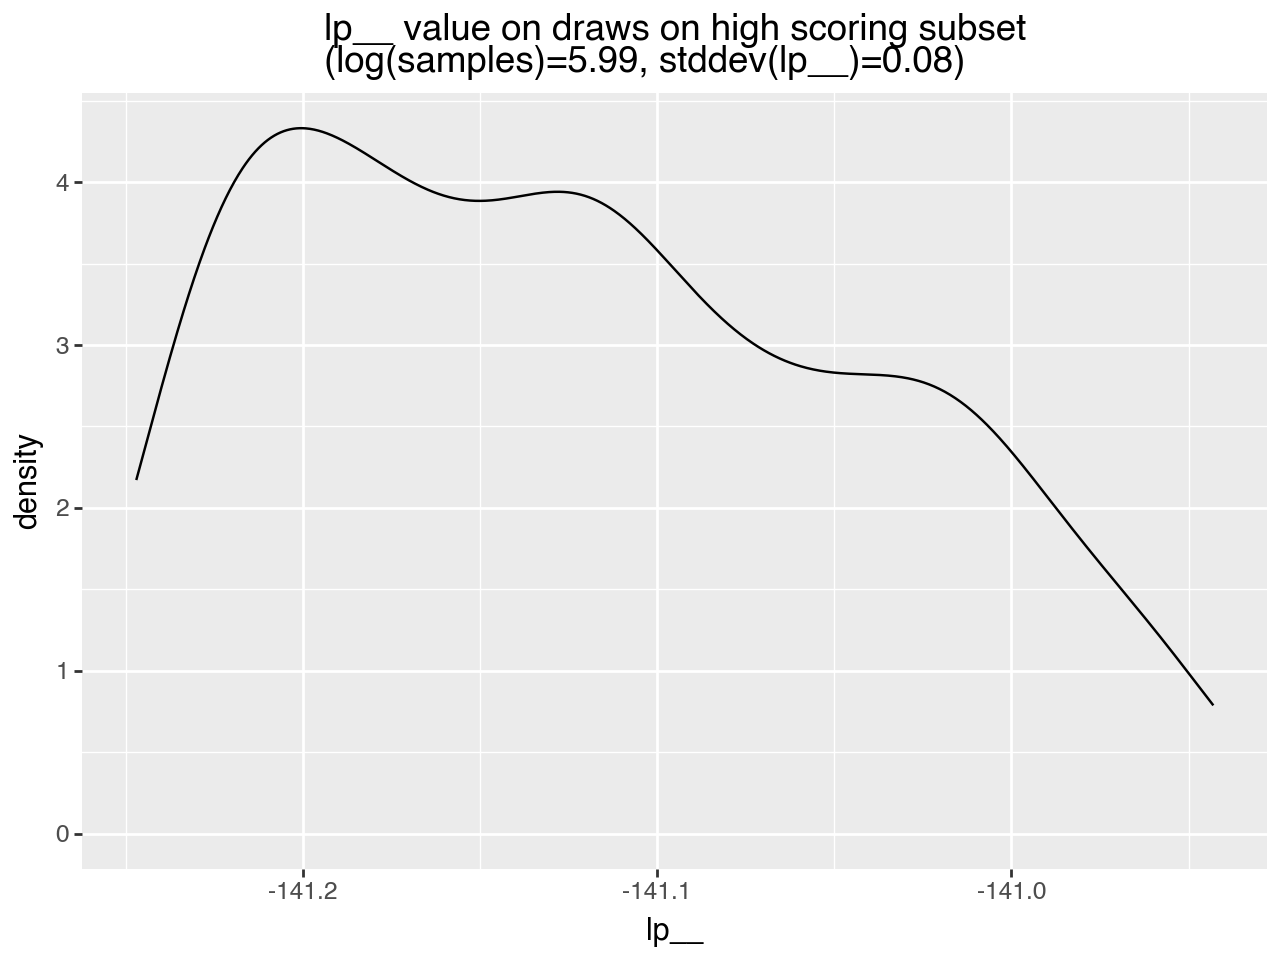

In [18]:
log_n_res_picked = np.log(res_picked.shape[0])
std_lp_picked = np.std(res_picked['lp__'])
(
    ggplot(
        data=res_picked,
        mapping=aes(x='lp__'),
    )
    + geom_density()
    + ggtitle(f"""lp__ value on draws on high scoring subset
(log(samples)={log_n_res_picked:.2f}, stddev(lp__)={std_lp_picked:.2f})""")
)

In [19]:
a = res_picked['a'].mean()
b = res_picked['b'].mean()

(a, b)

(0.34721258354114715, -0.910265536159601)

In [20]:
d_test['tobit prediction'] = np.maximum(
    0, 
    a * d_test['x'] + b)

d_test.head()

,x,y,y_ideal,ypred0,tobit prediction
0,2.643121,0.0,0.0,0.343526,0.007459
1,-2.531999,0.0,0.0,0.000000,0.000000
2,-5.911557,0.0,0.0,0.000000,0.000000
3,1.251704,0.0,0.0,0.235632,0.000000
4,-3.721379,0.0,0.0,0.000000,0.000000


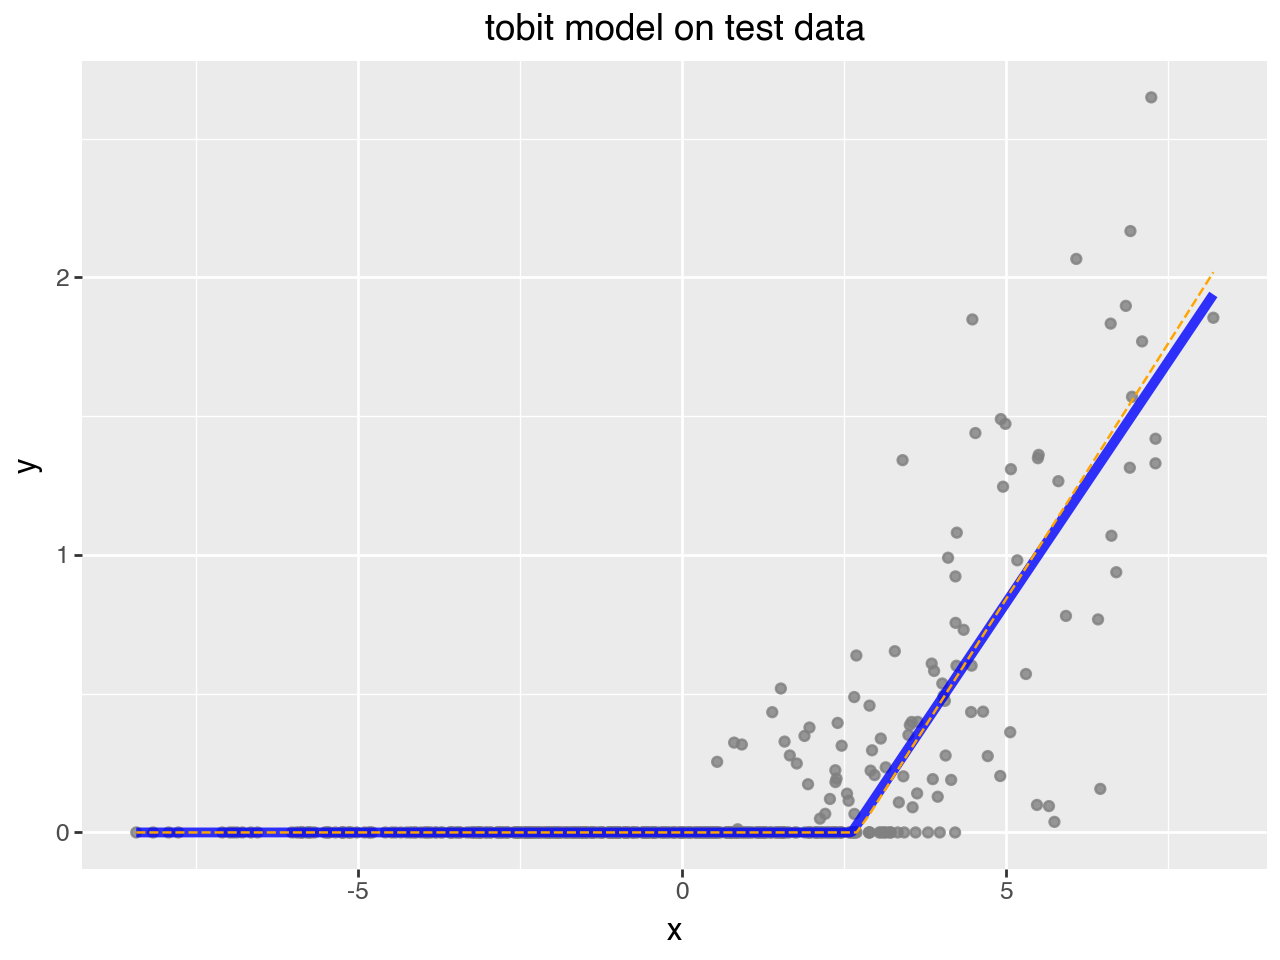

In [21]:
(
    ggplot(
        data=d_test, 
        mapping=aes(x='x', y='y')) + 
    geom_point(
        mapping=aes(y='y'),
        color="gray", alpha=0.8) +
    geom_line(
        mapping=aes(y='tobit prediction'),
        color="blue",
        alpha=0.8,
        size=2) +
    geom_line(
        mapping=aes(y='y_ideal'),
        color="orange", linetype='--') + 
    ggtitle("tobit model on test data")
)